# NFL Big Data Bowl - EDA
-------------------
TheNerdyCat <br>
27 Nov 2019 Deadline


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import seaborn as sns

import datetime
import kaggle
import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
import keras
import math

from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]
pd.options.display.max_columns = 100


In [59]:
#df = pd.read_csv("../input/nfl-big-data-bowl-2020/train.csv", low_memory=False)
#pd.DataFrame(df.columns).to_csv('train_cols.csv', index=False)

In [60]:
df = pd.read_csv("../input/nfl-big-data-bowl-2020/train.csv", low_memory=False)
df['ToLeft'] = df.PlayDirection == "left"

# Match the NFLId to that play's rusher's ID
df['IsBallCarrier'] = df.NflId == df.NflIdRusher 

# Correct differences in Team Name abbreviations
df.loc[df.VisitorTeamAbbr == "ARI", 'VisitorTeamAbbr'] = "ARZ"
df.loc[df.HomeTeamAbbr == "ARI", 'HomeTeamAbbr'] = "ARZ"
df.loc[df.VisitorTeamAbbr == "BAL", 'VisitorTeamAbbr'] = "BLT"
df.loc[df.HomeTeamAbbr == "BAL", 'HomeTeamAbbr'] = "BLT"
df.loc[df.VisitorTeamAbbr == "CLE", 'VisitorTeamAbbr'] = "CLV"
df.loc[df.HomeTeamAbbr == "CLE", 'HomeTeamAbbr'] = "CLV"
df.loc[df.VisitorTeamAbbr == "HOU", 'VisitorTeamAbbr'] = "HST"
df.loc[df.HomeTeamAbbr == "HOU", 'HomeTeamAbbr'] = "HST"

# New feature to show Dir in radians
df['Dir_rad'] = np.mod(90 - df.Dir, 360) * math.pi/180.0

It's really hard to tell which team is on offense friom the data! Even though the ball carrier is highlighted in black, the inconsistency from one play to the next is less than ideal. Sometimes the away team is on offense, other times the home team is on offense. And they're both potentially moving left or moving right.

Our ultimate goal will be to ensure that the offensive team (PossessionTeam) is moving left to right, even if in the raw data, the offense is moving right to left.

The following set of code will get us there.

In [61]:
df['TeamOnOffense'] = "home" # Dummy var
df.loc[df.PossessionTeam != df.HomeTeamAbbr, 'TeamOnOffense'] = "away"
df['IsOnOffense'] = df.Team == df.TeamOnOffense # Is player on offense?

df['YardLine_std'] = 100 - df.YardLine
df.loc[df.FieldPosition.fillna('') == df.PossessionTeam,  
          'YardLine_std'
         ] = df.loc[df.FieldPosition.fillna('') == df.PossessionTeam,  
          'YardLine']
df['X_std'] = df.X
df.loc[df.ToLeft, 'X_std'] = 120 - df.loc[df.ToLeft, 'X'] 
df['Y_std'] = df.Y
df.loc[df.ToLeft, 'Y_std'] = 160/3 - df.loc[df.ToLeft, 'Y'] 
df['Orientation_std'] = -90 + df.Orientation
#df.loc[df.ToLeft, 'Orientation_std'] = np.mod(180 + df.loc[df.ToLeft, 'Orientation_std'], 360)
df['Dir_std'] = df['Dir_rad']
df.loc[df.ToLeft, 'Dir_std'] = np.mod(np.pi + df.loc[df.ToLeft, 'Dir_rad'], 2*np.pi)

In [35]:
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

In [36]:
df['GameClock_sec'] = df['GameClock'].apply(strtoseconds)
df["GameClock_minute"] = df["GameClock"].apply(lambda x : x.split(":")[0]).astype("object")

In [44]:
df['PlayerHeight_inches'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

In [140]:
df.head(2)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,ToLeft,IsBallCarrier,Dir_rad,TeamOnOffense,IsOnOffense,YardLine_std,X_std,Y_std,Orientation_std,Dir_std,row_number
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,True,False,4.761607,home,False,35,46.09,18.493333,-8.01,1.620015,1
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW,True,False,4.386012,home,False,35,45.33,20.693333,-62.39,1.244420,2


In [145]:
df['row_number'] = df.groupby(['PlayId']).cumcount() + 1
# Extended dataframe
new_df = df.pivot_table(index=['PlayId'], columns=['row_number'], values=['X'])

In [146]:
columns = []
for c in new_df.columns:
    col_name = str(c[0]) + str(c[1])
    columns.append(col_name)
new_df.columns = columns

In [147]:
# If you want to add more variables just add them:
new_df = df.pivot_table(index=['PlayId'], columns=['row_number'], values=['X', 'Y', 'S'])

In [149]:
new_df.columns

MultiIndex(levels=[['Down', 'S', 'X', 'Y', 'Yards'], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]],
           codes=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]],
           names=[None, 'row_number'])

The below functions will plot plays onto a football field.

In [25]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12*2, 6.33*2)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0,  alpha=0.5)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax
#create_football_field()

In [26]:
def get_dx_dy(radian_angle, dist):
    dx = dist * math.cos(radian_angle)
    dy = dist * math.sin(radian_angle)
    return dx, dy

def show_play(play_id, df=df):
    df = df[df.PlayId == play_id]
    fig, ax = create_football_field()
    ax.scatter(df.X, df.Y, cmap='rainbow', c=~(df.Team == 'home'), s=100)
    rusher_row = df[df.NflIdRusher == df.NflId]
    ax.scatter(rusher_row.X, rusher_row.Y, color='black')
    yards_covered = rusher_row["Yards"].values[0]
    x = rusher_row["X"].values[0]
    y = rusher_row["Y"].values[0]
    rusher_dir = rusher_row["Dir_rad"].values[0]
    rusher_speed = rusher_row["S"].values[0]
    dx, dy = get_dx_dy(rusher_dir, rusher_speed)

    ax.arrow(x, y, dx, dy, length_includes_head=True, width=0.3, color='black')
    left = 'left' if df.ToLeft.sum() > 0 else 'right'
    plt.title(f'Play # {play_id} moving to {left}, yard distance is {yards_covered}', fontsize=20)
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


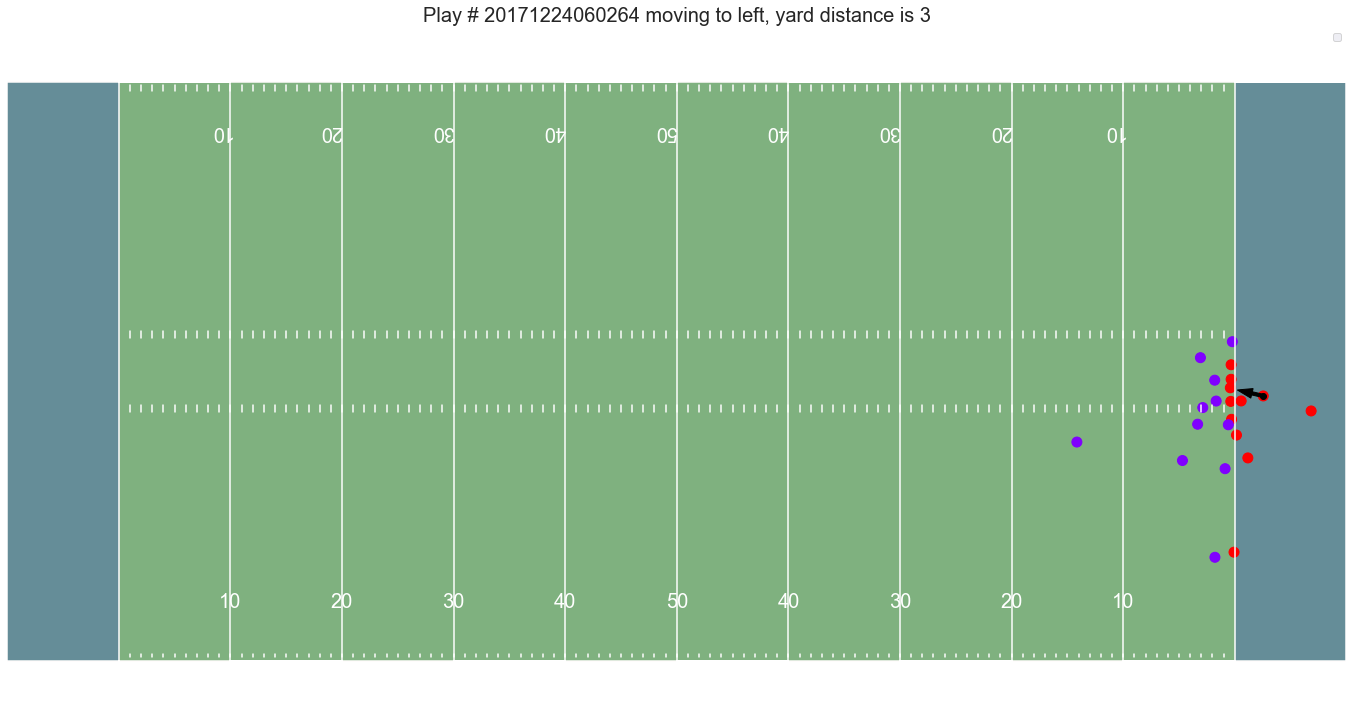

In [27]:
show_play(20171224060264)

In [ ]:
features = [c for c in train_df.columns.values if c not in rm_cols]
train_df = train_df[features]

In [ ]:
train_data=np.zeros((509762//22, len(features)))
for i in tqdm.tqdm(range(0,509762,22)):
    count=0
    for c in features:
        train_data[i//22][count] = train_df[c][i]
        count+=1

In [135]:
# The code below takes as input the df DataFrame with all rows from train.csv, 
# and outputs a summary DataFrame with one row per pay, with the column 
# distance_to_runner as the desired value.
# Also, you can see that I'm creating a data DataFrame. In it, I calculate the 
# distance from every player to the runner. From there, I can create lots of features.

plays = df[df['NflId'] == df['NflIdRusher']]
data = pd.merge(df, plays[['PlayId', 'X', 'Y']], on='PlayId',
                suffixes=('', '_r'))
data['distance_to_runner'] = ((data['X'] - data['X_r'])**2 +
                              (data['Y'] - data['Y_r'])**2)**(1/2)
summary = data.groupby(['PlayId', 'Team']).agg({'distance_to_runner': 'min'})
summary = summary[summary['distance_to_runner'] != 0]
summary.index = summary.index.get_level_values(0)

In [138]:
summary

,distance_to_runner
PlayId,
20170907000118,4.593310
20170907000139,4.287773
20170907000189,4.221670
20170907000345,4.528002
20170907000395,4.288088
20170907000473,4.213739
20170907000516,5.593943
20170907000653,3.303120
20170907000680,4.543677


In [ ]:
# I wrote the helper function below to combine all files within a 
# folder into a single file to submit in Kaggle.

def generate_submission(path=None, closing_file='_closing_submission.py',
                        submission_file='submissions/submission.py'):
    """This function combines all PY files into a single submission file, to
    be uploaded as a single script in Kaggle.

    Args:
        path (str): The path from within combine PY files. If None, will use
            current
        closing_file (str): The last file to be added to the submission file.
            It contains the final function to be executed in the script.
        submission_file (str): The final submission file

    """
    if path is None or not os.path.exists(path):
        path = os.getcwd()

    dest = open(os.path.join(path, submission_file), "w")
    for filename in os.listdir(path):
        if filename.endswith(".py") and not filename.startswith('_'):
            f = open(os.path.join(path, filename), "r")
            for line in f.readlines():
                if line.startswith('from nfl.'):
                    continue
                if line.startswith("if __name__ == "):
                    break

                dest.write(line)

            dest.write('\n\n')
            dest.write('#' + '*' * 79)
            dest.write('\n\n')
            f.close()

    if not os.path.exists(closing_file):
        raise ValueError('Closing file does not exist!')

    f = open(os.path.join(path, closing_file), "r")
    dest.write(f.read())
    dest.close()
    
    
    # Better organizing the code in a proper file structure helped 
    # me figure out faster & better ways to develop & improve my algorithms. It enabled my very final code becoming something very neat:
n_splits = 5
dataset = Dataset('/kaggle/input/nfl-big-data-bowl-2020/train.csv')
model1 = KerasModel(n_splits=n_splits, input_dim=103)
model2 = XGBModel(n_splits=n_splits)
model3 = LGBModel(n_splits=n_splits)
model4 = CatBoostModel(n_splits=n_splits)
ensemble = Ensemble(models=[model1, model2, model3, model4], dataset=dataset)
ensemble.train()
env = nflrush.make_env()
ensemble.make_submission(env)

In [ ]:
# I saw in another thread an implementation of CRPS score with 2 loops. 
# That's very slow, very inefficient. It follows a vectorized implementation, very fast:

def crps(y_pred, y_real):
    """This function takes as input the Y predictions (the distribution
    probability, shape N x 199) and the Y real (the actual completed yards,
    shape N) and outputs the Continuous Ranked Probability Score
    (CRPS). For more information, check:
    https://www.kaggle.com/c/nfl-big-data-bowl-2020/overview/evaluation

    Args:
        y_pred: Cumulative distribution probabilities predicted by the 
            model, shape N x 199, where N is the number of samples
        y_real: Real yards completed (target), shape N

    Returns:
        float: the Continuous Ranked Probability Score (CRPS)

    """
    n = np.arange(-99, 100)
    n = np.row_stack([n] * y_pred.shape[0])
    ym = y_real.reshape(y_pred.shape[0], 1)
    step = np.heaviside(n - ym, 1)

    total = np.mean((y_pred - step)**2)

    return total